<a href="https://colab.research.google.com/github/Himanshukunar/excelr-assignments/blob/main/Assignment8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using sheet: data | shape before cleaning: (3999, 12)
Data after outlier removal: 3919 rows, 10 features

=== Summary Statistics (numeric) ===
            Balance    Qual_miles    cc1_miles    cc2_miles    cc3_miles  \
count  3.919000e+03   3919.000000  3919.000000  3919.000000  3919.000000   
mean   6.858264e+04    125.572850     2.031896     1.012248     1.005359   
std    8.331816e+04    717.998035     1.356080     0.135006     0.124661   
min    0.000000e+00      0.000000     1.000000     1.000000     1.000000   
25%    1.826900e+04      0.000000     1.000000     1.000000     1.000000   
50%    4.154700e+04      0.000000     1.000000     1.000000     1.000000   
75%    8.881000e+04      0.000000     3.000000     1.000000     1.000000   
max    1.125076e+06  11148.000000     5.000000     3.000000     5.000000   

         Bonus_miles  Bonus_trans  Flight_miles_12mo  Flight_trans_12  \
count    3919.000000  3919.000000        3919.000000      3919.000000   
mean    15995.580505    11

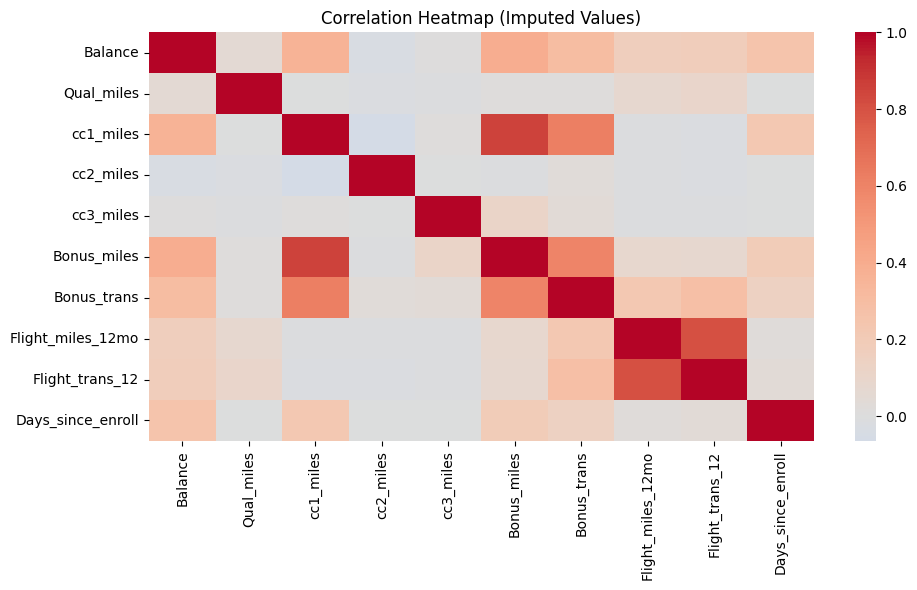

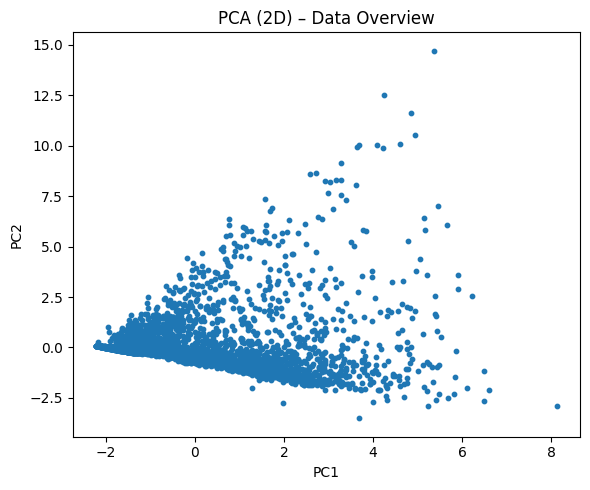


Best K (by silhouette): 2 | Silhouette=0.673


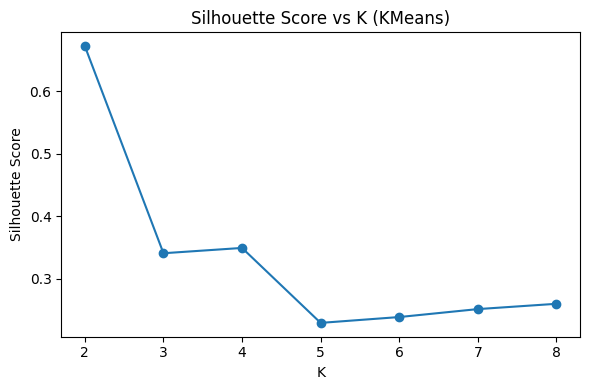

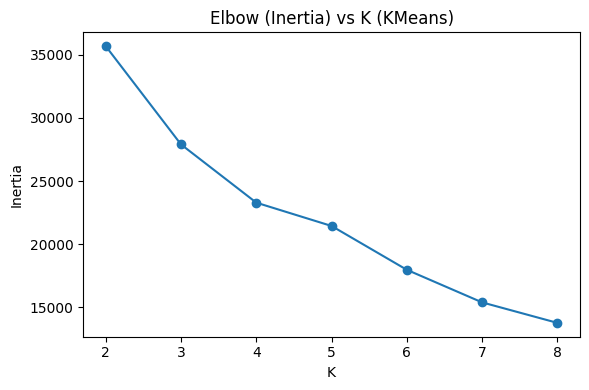

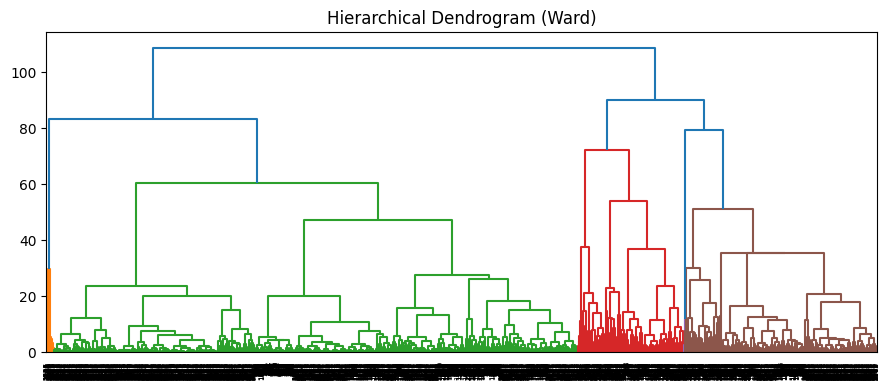

DBSCAN Silhouette (eps=1.5, min_samples=5): 0.568


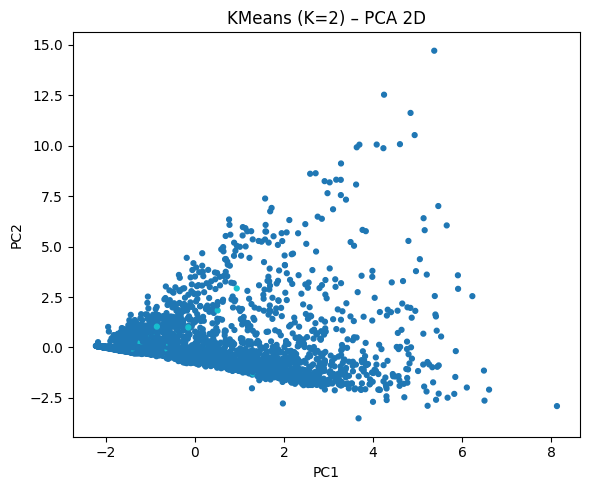

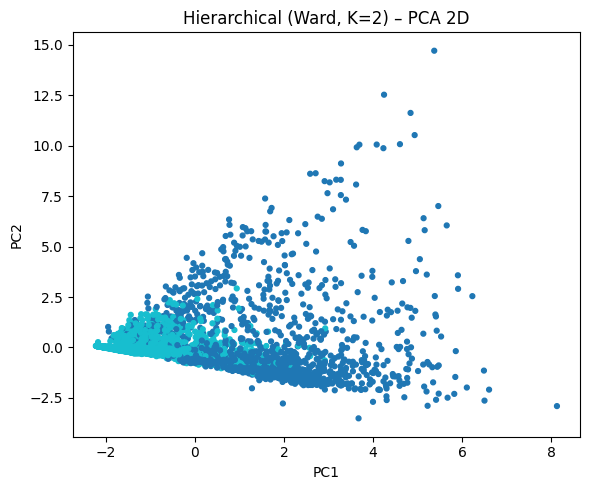

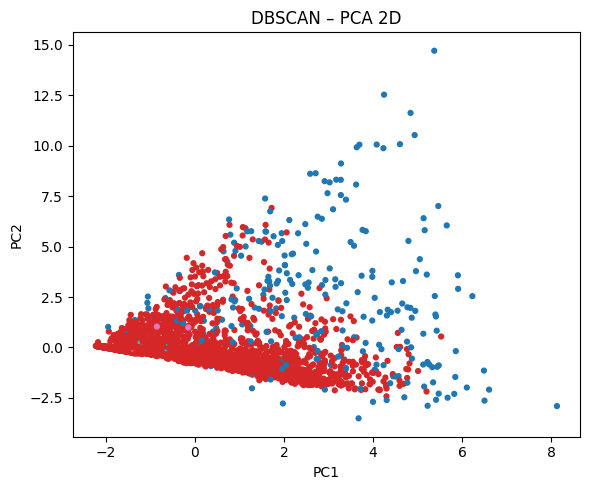


=== Cluster Profile: KMeans_Cluster ===
                 Balance  Qual_miles  cc1_miles  cc2_miles  cc3_miles  \
KMeans_Cluster                                                          
0               68835.01      126.74       2.04       1.00       1.01   
1               41361.97        0.00       1.08       2.33       1.00   

                Bonus_miles  Bonus_trans  Flight_miles_12mo  Flight_trans_12  \
KMeans_Cluster                                                                 
0                  16028.09        11.08             361.23             1.08   
1                  12489.00        14.22             208.33             0.67   

                Days_since_enroll  
KMeans_Cluster                     
0                         4090.16  
1                         3926.25  

=== Cluster Profile: Hier_Cluster ===
                Balance  Qual_miles  cc1_miles  cc2_miles  cc3_miles  \
Hier_Cluster                                                           
0             1061

In [8]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as sch
import warnings
warnings.filterwarnings("ignore")
FILE_PATH = "/content/EastWestAirlines.xlsx"
TARGET_COLS = {"Award?", "award?", "target"}
ID_COLS = {"ID#", "id", "Id", "ID"}
RANDOM_STATE = 42
CONTAMINATION = 0.02

all_sheets = pd.read_excel(FILE_PATH, sheet_name=None)
sheet_names = list(all_sheets.keys())

def pick_best_sheet(sheets_dict):

    for key in sheets_dict:
        if key.strip().lower() == "data":
            return key

    best_name, best_score = None, -1
    for name, df in sheets_dict.items():
        # score = count of numeric cells after coercion
        coerced = df.apply(lambda s: pd.to_numeric(s, errors="coerce"))
        score = coerced.notna().sum().sum()
        if score > best_score:
            best_name, best_score = name, score
    return best_name

data_sheet = pick_best_sheet(all_sheets)
df = all_sheets[data_sheet].copy()
print(f"Using sheet: {data_sheet} | shape before cleaning: {df.shape}")


df.columns = df.columns.map(lambda c: str(c).strip())
df = df.dropna(axis=1, how="all").dropna(axis=0, how="all").reset_index(drop=True)


df = df.drop_duplicates().reset_index(drop=True)

present_id_cols = [c for c in df.columns if c in ID_COLS]
present_target_cols = [c for c in df.columns if c in TARGET_COLS]

non_feature_cols = set(present_id_cols + present_target_cols)
for col in df.columns:
    if col not in non_feature_cols:
        df[col] = pd.to_numeric(df[col], errors="coerce")

feature_candidates = [c for c in df.columns if c not in non_feature_cols]
df = df.dropna(subset=feature_candidates, how="all").reset_index(drop=True)


num_features = [c for c in feature_candidates if np.issubdtype(df[c].dtype, np.number)]
if len(num_features) < 2:
    raise ValueError(f"Not enough numeric columns to cluster. Found: {num_features}")

X_num = df[num_features].copy()


imputer = SimpleImputer(strategy="median")
X_imp = imputer.fit_transform(X_num)


iso = IsolationForest(contamination=CONTAMINATION, random_state=RANDOM_STATE)
keep_mask = iso.fit_predict(X_imp) == 1
X_imp = X_imp[keep_mask]
df = df.loc[keep_mask].reset_index(drop=True)


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imp)

print(f"Data after outlier removal: {X_scaled.shape[0]} rows, {X_scaled.shape[1]} features")


print("\n=== Summary Statistics (numeric) ===")
print(pd.DataFrame(X_imp, columns=num_features).describe())

plt.figure(figsize=(10,6))
corr = pd.DataFrame(X_imp, columns=num_features).corr()
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap (Imputed Values)")
plt.tight_layout()
plt.show()


pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_2d = pca.fit_transform(X_scaled)

plt.figure(figsize=(6,5))
plt.scatter(X_2d[:,0], X_2d[:,1], s=10)
plt.title("PCA (2D) – Data Overview")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()

 KMEANS: SILHOUETTE SWEEP + BEST K
k_range = range(2, 9)
sil_scores = []
inertias = []

for k in k_range:
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init="auto")
    labels = km.fit_predict(X_scaled)
    sil_scores.append(silhouette_score(X_scaled, labels))
    inertias.append(km.inertia_)

best_k = k_range[int(np.argmax(sil_scores))]
print(f"\nBest K (by silhouette): {best_k} | Silhouette={max(sil_scores):.3f}")

plt.figure(figsize=(6,4))
plt.plot(list(k_range), sil_scores, marker="o")
plt.title("Silhouette Score vs K (KMeans)")
plt.xlabel("K")
plt.ylabel("Silhouette Score")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(list(k_range), inertias, marker="o")
plt.title("Elbow (Inertia) vs K (KMeans)")
plt.xlabel("K")
plt.ylabel("Inertia")
plt.tight_layout()
plt.show()

kmeans = KMeans(n_clusters=best_k, random_state=RANDOM_STATE, n_init="auto")
kmeans_labels = kmeans.fit_predict(X_scaled)

 HIERARCHICAL CLUSTERING (Ward) + DENDROGRAM
plt.figure(figsize=(9,4))
_ = sch.dendrogram(sch.linkage(X_scaled, method="ward"))
plt.title("Hierarchical Dendrogram (Ward)")
plt.tight_layout()
plt.show()

hier = AgglomerativeClustering(n_clusters=best_k, linkage="ward")
hier_labels = hier.fit_predict(X_scaled)

 DBSCAN: simple defaults + silhouette if >1 cluster
dbscan = DBSCAN(eps=1.5, min_samples=5)   # tweak if needed
db_labels = dbscan.fit_predict(X_scaled)
db_unique = set(db_labels)
if len(db_unique - {-1}) >= 2:  # at least 2 real clusters beyond noise
    db_sil = silhouette_score(X_scaled, db_labels)
    print(f"DBSCAN Silhouette (eps=1.5, min_samples=5): {db_sil:.3f}")
else:
    print("DBSCAN found <2 clusters (or mostly noise). Try tuning eps/min_samples.")
 VISUALIZE CLUSTERS IN PCA SPACE
def plot_clusters_2d(X2d, labels, title):
    plt.figure(figsize=(6,5))
    plt.scatter(X2d[:,0], X2d[:,1], c=labels, s=12, cmap="tab10")
    plt.title(title)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.tight_layout()
    plt.show()

plot_clusters_2d(X_2d, kmeans_labels, f"KMeans (K={best_k}) – PCA 2D")
plot_clusters_2d(X_2d, hier_labels,  f"Hierarchical (Ward, K={best_k}) – PCA 2D")
plot_clusters_2d(X_2d, db_labels,    "DBSCAN – PCA 2D")
CLUSTER SUMMARIES (means per cluster)
def cluster_profile(df_original, numeric_cols, labels, label_name):
    prof = df_original.assign(**{label_name: labels}) \
                      .groupby(label_name)[numeric_cols] \
                      .mean().round(2)
    print(f"\n=== Cluster Profile: {label_name} ===")
    print(prof)
    return prof

kmeans_profile = cluster_profile(pd.DataFrame(X_imp, columns=num_features), num_features, kmeans_labels, "KMeans_Cluster")
hier_profile   = cluster_profile(pd.DataFrame(X_imp, columns=num_features), num_features, hier_labels,   "Hier_Cluster")
 SAVE OUTPUT WITH LABELS
out = df.copy()
out.loc[:, "KMeans_Cluster"] = kmeans_labels
out.loc[:, "Hier_Cluster"]   = hier_labels
out.loc[:, "DBSCAN_Label"]   = db_labels

save_path = "clustered_output.xlsx"
with pd.ExcelWriter(save_path, engine="xlsxwriter") as w:
    out.to_excel(w, sheet_name="data_with_clusters", index=False)
    kmeans_profile.to_excel(w, sheet_name="kmeans_profile")
    hier_profile.to_excel(w, sheet_name="hier_profile")

print(f"\nSaved labeled data & profiles -> {save_path}")


In [7]:
%pip install xlsxwriter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 3.8 MB/s eta 0:00:00
